# Introduction

A challenge for single-trial analysis of neural data is the trial-to-trial variability in the spiking of individual neurons. In order to estimate neuron firing rates for different task conditions, data is typically averaged across many trials, and thus single-trial information is lost.  

If some structure on neural data was uncovered, this structure could be leveraged to better infer the firing rates of neurons from variable single-trial data. In relation to this, the activity of large populations of neurons has been shown to be well described by low-dimensional dynamics in many brain areas. 

[LFADS](https://www.nature.com/articles/s41592-018-0109-9) is a machine-learning method based on non-linear artificial recurrent neural networks (RNNs) for inferring single-trial population dynamics from neural spiking data. LFADS takes this neural spiking data as an input and estimates the data's latent dynamics and de-noised neuron firing rates. No trial-specific information or behavioral information is required. When applied to a variety of datasets, the rates extracted by LFADS have been shown to estimate behavioral variables more accurately than other techniques.


This tutorial aims to introduce some of the concepts necessary for understading the inner workings of LFADS. Specifically, this tutorial will cover:
*   An overview of dynamical systems
*   Using recurrent networks to model dynamical systems
*   Modeling the firing rates of a large population of neurons using low-dimensional dynamics
*   Sequential autoencoders as a tool for inferring single-trial firing rates from spiking data

The tutorial is structured such that we will build step-by-step onto an LFADS-like model. By the end, we will have built and trained a model to estimate neuron firing rates from (synthetic) single-trial spiking data. 



### Instructions

*   Make a copy of notebook: *File>Save a copy* in Drive
*   Set the notebook hardware accelerator to GPU. In the menu bar, select *Runtime>Change runtime type>Hardware accelerator: GPU*. This will make model training much faster.
*   Read and run each block of code sequentially as they come up. It is suggested to study each code block and the comments that accompany it.



In [ ]:
#@title Import Dependencies
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from numpy.random import rand
import numpy as np
from scipy.integrate import odeint
 
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

print('Done')

# Part 1: Overview of dynamical systems

A dynamical system is a system which evolves in time, for which the rules defining this time evolution can be described using a set of differential equations:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u},t)$

where $\mathbf{x}$ is the state of the system, $\mathbf{u}$ are external inputs to the system, $t$ is time and $\dot{\mathbf{x}}$ is short-hand notation for $\frac{d\mathbf{x}}{dt}$, that is, the derivative of $\mathbf{x}$ with respect to time. The above equation then defines the rate of change of the system state as a function of the current state, external inputs and time. 

In the case where the dynamical system does not depend on time (time-invariant) and there are no external inputs (autonomous), the system's equations are simplified to:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x})$

In other words, given a certain state $\mathbf{x}$, we can compute the direction in which this state will evolve across time.

## 1.1. Linear dynamical systems
We will be using two different dynamical systems throughout this tutorial. The first belongs to a family of dynamical systems known as **linear** dynamical systems, which are such that the system equations are linear and can be represented as a matrix operation:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}) = \mathbf{A}\mathbf{x}$

Particularly, we will work with a 2D linear system for which:

$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix}\begin{bmatrix}x_1 \\ x_2\end{bmatrix}$

We will see shortly that this system corresponds to an oscillator, since the trajectories which fit these equations oscillate around a point. 


In [ ]:
### Define equations for a 2D linear oscillator

def f_osc(x, t):

  # separate state variables
  x1 = x[0]
  x2 = x[1]

  # define differential equations
  dx1dt = x2
  dx2dt = -x1
  
  return np.array([dx1dt, dx2dt])

print('Done')

A way to visualize the dynamics of a system is using vector fields, which evaluate $\mathbf{f}(\mathbf{x})$ at different points, and thus show the direction and rate of change of the system through state-space.

In [ ]:
### Define 2d quiver plot function

def plot_2d_quiver(f, ax, xlims=(-1.5,1.5), ylims=(-1.5,1.5)):
  
  # extract plot limits
  xmin = xlims[0]
  xmax = xlims[1]
  ymin = ylims[0]
  ymax = ylims[1]
  
  # setup plot
  ax.set_xlim([xmin,xmax])
  ax.set_ylim([ymin,ymax])
  ax.set_xlabel("$x_1$")
  ax.set_ylabel("$x_2$")

  # compute and plot vectors for different values in state-space
  y1 = np.linspace(xmin, xmax, 20)
  y2 = np.linspace(ymin, ymax, 20)
  Y1, Y2 = np.meshgrid(y1, y2)
  u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
  NI, NJ = Y1.shape
  for i in range(NI):
    for j in range(NJ):
      x = Y1[i, j]
      y = Y2[i, j]
      yprime = f([x, y], 0)
      u[i,j] = yprime[0]
      v[i,j] = yprime[1]
  ax.quiver(Y1, Y2, u, v, color='gray')

print('Done')

We plot the vector field for the oscillator, as well as the trajectories for different initial conditions.

In [ ]:
### Plot vector field for 2D linear oscillator

# initialize plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.title("Vector field for linear oscillator")
# plot vector field
plot_2d_quiver(f_osc, ax)

Note how for any point in space, the direction of the vector field rotates around the origin, showing that this corresponds to an oscillator. 

We will now plot the trajectories for the state starting at different initial conditions.

In [ ]:
### Plot trajectories for 2D linear oscillator starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
  # plot vector field
  plot_2d_quiver(f_osc, ax[i])
  # generate random initial condition between -1 and 1
  x0 = 2*(np.random.rand(1,2) - 0.5)
  # generate trajectory by integrating system differential equations, given an initial condition
  x = odeint(f_osc, x0[0,:], t)
  # plot initial condition (shown by dot)
  ax[i].plot(x[0,0],x[0,1],'bo')
  ax[i].set_title('Initial condition: ({:4.2f}, {:4.2f})'.format(x[0,0],x[0,1]))
  # plot trajectory
  ax[i].plot(x[:,0],x[:,1],'b--')

In the above plots, different initial conditions (dots) and the resulting trajectory (dashed line) are shown. We see that there are consistent rules which govern how the trajectories evolve through time. Also, we see that the trajectories themselves only depend on the initial conditions and evolve autonomously from there. So, we can represent the whole trajectory only with knowledge of the initial state and the system rules. 

## 1.2. Nonlinear dynamical systems

A more general family of dynamical systems are those known as **nonlinear** dynamical systems, for which $\mathbf{f}(\mathbf{x})$ cannot be represented as a matrix transform. This type of systems allows much richer trajectories than linear ones, and real-world systems are usually better represented by nonlinear dynamics. For this tutorial, we will work with a Lorenz attractor, which is a 3-dimensional nonlinear system described by the following equations:

$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3\end{bmatrix} = \begin{bmatrix}\sigma(x_2-x_1) \\ x_1(\rho-x_3) - x_2 \\ x_1x_2 - \beta x_3 \end{bmatrix} $

With parameters $\sigma=10$, $\beta=8/3$, and $\rho=28$.

This system describes quite complex trajectories, as shown in the following animation:

![](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif)

In [ ]:
## Define equations for a Lorenz system

def f_lorenz(x,t):

  # separate state variables
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]

  # define system parameters
  sigma = 10
  beta = 8/3
  rho = 28

  # define differential equations
  dx1dt = sigma*(x2-x1)
  dx2dt = x1*(rho-x3) - x2
  dx3dt = x1*x2 - beta*x3
  
  return np.array([dx1dt, dx2dt, dx3dt])

print('Done')

Visualizing vector fields is harder in 3D, so we will skip that step for this system, and plot the state trajectories starting at different initial conditions:

In [ ]:
### Plot trajectories for Lorenz system starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig = plt.figure(figsize=(20, 5), constrained_layout=True)

for i in range(4):
  # initialize 3D plot axes
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.set_xlim3d(left=-30, right=30)
  ax.set_ylim3d(bottom=-30, top=30)
  ax.set_zlim3d(bottom=0, top=50)
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_zlabel('$x_3$')
  # generate random initial condition between -10 and 10
  x0 = 20*(np.random.rand(1,3) - 0.5)
  # generate trajectory by integrating system differential equations, given an initial condition
  x = odeint(f_lorenz, x0[0,:], t)
  # plot initial condition (shown by dot)
  ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
  ax.set_title('Initial condition: ({:4.2f}, {:4.2f}, {:4.2f})'.format(x[0,0],x[0,1],x[0,2]))
  # plot trajectory
  ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')

Again, initial conditions are shown as a dot, followed by a dashed line indicating the resulting trajectory. Note how in this case, the shape of the trajectories is more complex than those obtained for the 2D linear oscillator. We can also add the time evolution of each state to the previous plot, for the same initial conditions (different initial condition trials are color coded for clarity):

In [ ]:
### Plot trajectories and time evolution for Lorenz system starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig = plt.figure(figsize=(20, 12), constrained_layout=True)
gs = fig.add_gridspec(11, 4)

for i in range(4):
  # initialize 3D plot axes
  ax = fig.add_subplot(gs[0:4,i], projection='3d')
  ax.set_xlim3d(left=-30, right=30)
  ax.set_ylim3d(bottom=-30, top=30)
  ax.set_zlim3d(bottom=0, top=50)
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_zlabel('$x_3$')
  # generate random initial condition between -10 and 10
  x0 = 20*(np.random.rand(1,3) - 0.5)
  # generate trajectory by integrating system differential equations, given an initial condition
  x = odeint(f_lorenz, x0[0,:], t)
  # plot initial condition (shown by dot)
  ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'o',color=(0, 0.25*i, 1-0.25*i))
  ax.set_title('Initial condition: ({:4.2f}, {:4.2f}, {:4.2f})'.format(x[0,0],x[0,1],x[0,2]))
  # plot trajectory
  ax.plot3D(x[:,0],x[:,1],x[:,2],'--',color=(0, 0.25*i, 1-0.25*i))

  # plot time evolution for x1 
  ax = fig.add_subplot(gs[5:7,i])
  ax.plot(t, x[:,0],'--',color=(0, 0.25*i, 1-0.25*i))
  ax.set_ylim([-30,30])
  ax.set_title('Time evolution of system states')
  ax.set_ylabel('$x_1$')
  # plot time evolution for x2 
  ax = fig.add_subplot(gs[7:9,i])
  ax.plot(t, x[:,1],'--',color=(0, 0.25*i, 1-0.25*i))
  ax.set_ylim([-30,30])
  ax.set_ylabel('$x_2$')
  # plot time evolution for x3 
  ax = fig.add_subplot(gs[9:11,i])
  ax.plot(t, x[:,2],'--',color=(0, 0.25*i, 1-0.25*i))
  ax.set_ylim([0,50])
  ax.set_ylabel('$x_3$')
  ax.set_xlabel('Time [s]')

Note how differences in the initial condition lead to very different trajectories through time. But again, these trajectories can be fully determined just from the initial state.

If we proceed to plot several trajectories at the same time:

In [ ]:
### Plot trajectories for Lorenz system for multiple initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in range(20):
  x0 = 10*2*(np.random.rand(1,3) - 0.5)
  x = odeint(f_lorenz, x0[0,:], t)

  ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')
  ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Trajectories for Lorenz system for multiple initial conditions')

When several trajectories are plotted, the structure of the system becomes apparent. We can see that there are consistent rules which govern how the trajectories evolve through time, despite how complex these seem. 

As mentioned, it is possible to predict the evolution of the system from knowledge of the dynamics and initial conditions. These two points are some of the main ideas that LFADS leverages for inferring single-trial neuron population dynamics, and are key for the steps that follow.

# Part 2: Models for approximating dynamical systems

In the previous section we saw that with knowledge of the equations which define a dynamical system, and given a certain initial condition, it is possible to predict the time evolution of the system. 

Up to now, we have computed the trajectories which arise from an initial condition through numerical integration of the system's differential equations (using Scipy's `odeint`). An alternative when working with discrete time samples is to approximate these dynamics through a recurrence equation:

$\mathbf{x}[k+1] = \hat{\mathbf{f}}(\mathbf{x}[k])$

If we can estimate the function $\hat{\mathbf{f}}$, we would be able to recursively generate predictions for future values of the state given a starting value.

## 2.1. Approximating linear dynamics

In the case of a linear system like the linear oscillator, $\hat{\mathbf{f}}$ corresponds to a matrix operation:

$\mathbf{x}[k+1] = \hat{\mathbf{A}}\mathbf{x}[k]$

Particularly in the case of a 2D linear system (like the oscillator we studied in the previous section), this can be written as:

$\begin{bmatrix}x_1[k+1] \\ x_2[k+1]\end{bmatrix} = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22}\end{bmatrix}\begin{bmatrix}x_1[k] \\ x_2[k]\end{bmatrix}$

We could analytically compute the terms $a_{ij}$ from the differential equations we have defined. In practice though, the exact dynamics of a system are not known. An option is to fit these parameters to recorded trajectories from the system by minimizing some error metric between the measurements and model predictions (e.g. sum of squared errors). 

We will try this out now, but first, we generate some trajectories for training and validating a linear model:

In [ ]:
### Generate training and validation data for 2D oscillator
# training data is used to fit the model
# validation data is held out from training and used to evaluate model 

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 2      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# set parameters for generating data 
sequence_length = int(T/dt)
real_state_dim = 2

# define total number of trajectories
N_all = 100
# 80% of data will be sued for training, and the rest for validation
N_train = int(0.8*N_all)
N_validate = N_all - int(0.8*N_all)

# define equations to use for generating trajectories (2D oscillator in this case)
f = f_osc

# define container for data trajectories, size: (# trials) x (# time samples) x (# states)
Y_all = np.zeros((N_all,sequence_length, real_state_dim))
# define container for data initial conditions, size: (# trials) x (# states)
X_all_ics = np.zeros((N_all, real_state_dim))
# generate training data for (N_train) trials/trajectories
for i in range(N_all):
  # generate initial condition for trial i and save to container
  x0_i = 2*(np.random.rand(1,real_state_dim)-0.5)
  X_all_ics[i,:] = x0_i
  # generate trajectory for trial i and save to to container
  Y_all_i = odeint(f,x0_i[0,:],t)
  Y_all[i,:,:] = np.reshape(Y_all_i,(1,Y_all_i.shape[0],Y_all_i.shape[1]))

# separate data into training and validation data
Y_train = Y_all[0:N_train]
Y_validate = Y_all[N_train:]
X_train_ics = X_all_ics[0:N_train]
X_validate_ics = X_all_ics[N_train:]

print('2D oscillator: {} trials generated for training, {} trials generated for validation'.format(Y_train.shape[0],Y_validate.shape[0]))

As mentioned, an option to fit the parameters for the linear models is to minimize some error metric between the measurements and model predictions. For this example, we will minimize the sum of square errors between the trajectory data $\mathbf{x}[k+1]$ and model predictions $\hat{\mathbf{x}}[k+1]$, across trials and time samples. That is, the metric which we want to minimize is:

$\sum_{i}^{\# trials}\sum_{k}^{\# samples}\|\mathbf{x}_i[k+1] - \hat{\mathbf{x}}_i[k+1]\|^2 $
$= \sum_{i}^{\# trials}\sum_{k}^{\# samples}\|\mathbf{x}_i[k+1] - \hat{\mathbf{A}}\mathbf{x}_i[k]\|^2$ 

To apply the linear least squares method, we need to write the above in the following form:

$\|\mathbf{y}- \mathbf{X}\mathbf{\beta}\|^2$

where $\mathbf{y}$ is a vector of model outputs, $\mathbf{X}$ is a matrix with the model inputs, and $\mathbf{\beta}$ is a vector with the model parameters.

Written this way, the parameters $\hat{\mathbf{\beta}}$ which minimize the sum of square errors are the following:

$\hat{\mathbf{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In the following block of code, we build vector $\mathbf{y}$ and matrix $\mathbf{X}$ by stacking the data from all samples and trials, and apply the linear least squares method to obtain parameters for the linear model. 





In [ ]:
### Fit parameters of linear model thorugh linear least squares method

# we don't actually need to use the whole trajectories for training the model
# doing so would lead to huge matrices being computed during the least squares methods
# so we use only a fraction of the samples from each trial for training 
# which is more efficient and results in good fit results
samples_training = 10

# define containers for least squares method matrices
X = np.zeros((2*N_train*samples_training, 4))
y = np.zeros((2*N_train*samples_training,1))
# loop over training trials and time samples to fill least squares method matrices
for i in range(N_train):
  for j in range(samples_training):
    row = 2*i*samples_training+2*j
    # stack values corresponding to predicitons for the next value of x1
    y[row] = Y_train[i, j+1, 0]
    X[row, 0] = Y_train[i, j, 0]
    X[row, 1] = Y_train[i, j, 1]
    # stack values corresponding to predicitons for the next value of x2
    y[row+1] = Y_train[i, j+1, 1]   
    X[row+1, 2] = Y_train[i, j, 0]
    X[row+1, 3] = Y_train[i, j, 1]
    
# compute model parameters using data matrices
beta = np.linalg.inv(X.T@X)@X.T@y
beta = np.ravel(beta)
print("Parameters fitted for linear model: a11, a12, a21, a22 = {}".format(beta))

Using the fitted parameters, let's evaluate how the trajectories generated from the model compare to the real validation data (which was not used for fitting the parameters).

In [ ]:
### Evaluate linear model for estimating 2D oscillator dynamics on validation data

# build model matrix using fitted parameters
A_d = np.array([[beta[0], beta[1]],[beta[2], beta[3]]])

# define container for predicted trajectories
Y_predict = np.zeros_like(Y_validate)
# generate trajectories using model
for i in range(N_validate):
  # start from an initial condition
  x_j = X_validate_ics[i,:]
  # recursively compute rest of trajectory
  for j in range(sequence_length):
    Y_predict[i, j] = x_j
    x_j = A_d@x_j

# plot real and predicted trajectories
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title('Real trajectories')
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
ax[1].set_title('Predicted trajectories')
for i in range(10):
  # plot real trajectories
  ax[0].plot(Y_validate[i,:,0], Y_validate[i,:,1], 'b', )
  ax[0].plot(Y_validate[i,0,0], Y_validate[i,0,1],'bo')
  # plot predicted trajectories
  ax[1].plot(Y_predict[i,:,0], Y_predict[i,:,1], 'r')
  ax[1].plot(Y_predict[i,0,0], Y_predict[i,0,1],'ro')
plt.show()

Visually, there is no noticeable difference between the real data and that generated by the model, so the oscillator dynamics seem to be approximated very well by the model. 

We may also evaluate this quantitatively using the coefficient of determination ($R^2$). A value of $R^2=1$ indicates that the predicted values perfectly match the real values, while $R^2=0$ means the model has the same performance as a model which always predicts the average of the real data (thus 0 is the baseline value).

Let's compute the $R^2$ metric between the real data and model predictions:

In [ ]:
### Define coefficient of determination (R^2) funciton 

# import R^2 function
from sklearn.metrics import r2_score

def compute_R2(y_true, y_pred):
  # compute R^2 score for each trial
  trial_R2 = np.zeros((y_true.shape[0],1))
  for i in range(y_true.shape[0]):
    trial_R2[i] = r2_score(y_true[i], y_pred[i])
  # return average score across all trials
  return np.mean(trial_R2)

### Compute R^2

print('R^2 metric: {}'.format(compute_R2(Y_validate, Y_predict)))

The $R^2$ metric is basically 1, so the model is almost as good as can be. Fitting the model in this case was simple: being a linear system, we could represent the dynamics using a simple set of linear equations, and fitting the parameters for these was straightforward.

The state trajectories which can be described by linear models are limited though, and in practice biological systems tend to be better represented by nonlinear models. Thus we also need to address the problem of fitting a nonlinear model to data.

## 2.2. Approximating nonlinear dynamics

How do we approach this problem if the data cannot be approximated by a linear model, as was the case for the 2D oscillator (where the underlying dynamics were in fact linear)? There is a significant difference in complexity between linear and nonlinear dynamics, such that we cannot assume that a model $\hat{\mathbf{f}}(\mathbf{x}[k])$ in the form of a matrix operation will work in the case of the latter. 

Recurrent neural networks (RNNs) are a type of artificial neural network designed to solve this particular problem. They allow to model nonlinear temporal behavior relating a sequence of inputs and outputs, and are thus referred to as "universal approximators" for dynamical systems. 

For implementing the RNN-based models for the following steps, we will use the Keras API which allows to build deep-learning models on Tensorflow. 

In [ ]:
#@title Import Tensforflow/Keras Dependencies
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, RNN, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.utils import plot_model

print('Done')

We will now build and train an RNN-based model to approximate the dynamics for the Lorenz system. As before, we first generate training and validation data:

In [ ]:
### Generate training and validation data for Lorenz system
# training data is used to fit the model
# validation data is held out from training and used to evaluate model 

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 1      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# set parameters for generating data 
sequence_length = int(T/dt)
real_state_dim = 3

# define total number of trajectories
N_all = 1000
# 80% of data will be used for training, and the rest for validation
N_train = int(0.8*N_all)
N_validate = N_all - int(0.8*N_all)

# define equations to use for generating trajectories (lorenz system in this case)
f = f_lorenz

# define container for data trajectories, size: (# trials) x (# time samples) x (# states)
Y_all = np.zeros((N_all,sequence_length, real_state_dim))
# define container for data initial conditions, size: (# trials) x (# states)
X_all_ics = np.zeros((N_all, real_state_dim))
# Keras RNNs require an input sequence, but since we are working with an autonomous model,
# we define this input sequences as arrays of zeros
X_all_inputs = np.zeros((N_all,sequence_length,1))
# generate training data for (N_train) trials/trajectories
for i in range(N_all):
  # generate initial condition for trial i and save to container
  x0_i = 20*(np.random.rand(1,real_state_dim)-0.5)
  X_all_ics[i,:] = x0_i
  # generate trajectory for trial i and save to to container
  Y_all_i = odeint(f,x0_i[0,:],t)
  Y_all[i,:,:] = np.reshape(Y_all_i,(1,Y_all_i.shape[0],Y_all_i.shape[1]))

# separate data into training and validation data
Y_train = Y_all[0:N_train]
Y_validate = Y_all[N_train:]
X_train_ics = X_all_ics[0:N_train]
X_validate_ics = X_all_ics[N_train:]
X_train_inputs = X_all_inputs[0:N_train]
X_validate_inputs = X_all_inputs[N_train:]

print('Lorenz system: {} trials generated for training, {} trials generated for validation'.format(Y_train.shape[0],Y_validate.shape[0]))


RNNs are composed of several units, each with its own internal state. The vector representing the states of all units is denoted as $\mathbf{h}$. The number of units does not have to correspond to the dimensionality of the dynamics being modeled, and in fact can be significantly higher. For this tutorial we will be using 32 units for the RNNs we implement (this is an arbitrary value which works well for this example tutorial, but in practical applications this parameter may have to be tuned). 

At each time sample $t$, all units receive an input $\mathbf{x}_t$ (not to be confused with the state $\mathbf{x}$ from previous sections). From this input and the value of the internal state of all units from the previous sample $\mathbf{h}_{t-1}$, the RNN computes an output value $\mathbf{o}_t$.  This is represented in the following figure:
![](https://miro.medium.com/max/2068/1*SKGAqkVVzT6co-sZ29ze-g.png) (Source: https://medium.com/deeplearningbrasilia/deep-learning-recurrent-neural-networks-f9482a24d010)

There are several types of units which can be used to construct an RNN, popular ones being the LSTM and GRU units. For this tutorial, we will be using the GRU unit.

Using the Keras API, we now build an RNN for approximating the dynamics of the Lorenz model.

In [ ]:
### Define RNN model for generating Lorenz trajectories from initial condition

# define number of RNN units
hidden_state_dim = 32

# initial condition input to model
initial_condition = Input(shape=(real_state_dim), name='initial_condition')
# the RNN's hidden state is of different dimension that the Lorenz system's
# so we add a dense network to map the Lorenz initial condition to the RNN's initial hidden state
dense_h = Dense(hidden_state_dim, name='x0_to_h0')(initial_condition)
# the RNN requires a sequence of inputs
# since we are working with an autonomous system, we define a placeholder input of zeros
input_layer = Input(shape=(sequence_length,1),name='external_inputs')
# define an RNN with 'hidden_state_dim', and connect both previous layers as inputs
h = GRU(hidden_state_dim, return_sequences = True, name='generator')(input_layer, initial_state=[dense_h])
# add a dense network to map hidden state to dynamical system state 
x = Dense(real_state_dim, name='h_to_x')(h)
# define input/output model with all of the above
model_lorenz = Model(inputs=[input_layer, initial_condition], outputs=x) 
#model_lorenz.summary()
# plot a diagram of the model
plot_model(model_lorenz, show_shapes=True)

Now that the model is defined, we proceed to train it. 

We can't compute a closed form solution to find the optimal parameters for this type of models. Instead, they are optimized through an iterative algorithm (gradient descent). In this case, the target metric which we aim to optimize is the mean squared error.

Running the following block of code should take a couple of minutes. Make sure hardware acceleration using GPU was enabled! You should be able to visualize how the error metric for the model decreases during training, both for the training data and validation data (which is not involved in training, but is also evaluated for comparison).

In [ ]:
### Train Model

model_lorenz.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
history=model_lorenz.fit([X_train_inputs, X_train_ics] , Y_train , epochs=1000, batch_size=64, validation_data=([X_validate_inputs, X_validate_ics], Y_validate), verbose=2)

When the above training is finished, we can validate the trained model:

In [ ]:
# generate predicted trajectories using model
Y_predict = model_lorenz.predict([X_validate_inputs, X_validate_ics])

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# plot real and predicted trajectories
for i in range(10):
  # plot real trajectories
  ax.plot3D(Y_validate[i,:,0], Y_validate[i,:,1], Y_validate[i,:,2],'b--')
  ax.plot3D(Y_validate[i,0:1,0], Y_validate[i,0:1,1], Y_validate[i,0:1,2],'bo')
  # plot predicted trajectories
  ax.plot3D(Y_predict[i,:,0], Y_predict[i,:,1], Y_predict[i,:,2],'r--')
  ax.plot3D(Y_predict[i,0:1,0], Y_predict[i,0:1,1], Y_predict[i,0:1,2],'ro')
sample_lines = [plt.Line2D([0], [0], color='b', linestyle='--'),  plt.Line2D([0], [0], color='r', linestyle='--')]
labels = ['Real trajectories', 'Predicted trajectories']
plt.legend(sample_lines, labels)

Note how the predicted trajectories (in red) resemble the real trajectories (blue) reasonably well. The above plots are for initial conditions not used during training, so the model had no way of directly learning the trajectories themselves, but instead learned the recurrence rules for generating these (which correspond to the system dynamics). If we compute the $R^2$ metric in this case:


In [ ]:
### Compute R^2

print('R^2 metric: {}'.format(compute_R2(Y_validate, Y_predict)))

We get a very high $R^2$ metric, though visual inspection shows minor discrepancies between the real and predicted trajectories. A reason for this is that the model we used is quite basic, and in practice there are several ways to improve model performance (which we will not cover here). Also, the model was not trained with that much data (~1000 sequences), nor for very long.

# Part 3: Estimating low-dimensional dynamics in high-dimensional data

We have shown that state trajectories following the rules of some underlying dynamical system can be predicted with knowledge of the dynamical system's rules and the initial state. We have also shown that there are different methods for approximating these dynamical system rules from data. Particularly, RNNs are able to approximate the dynamics of nonlinear systems. But, how does this relate to neural data?

Several works have shown that in many brain areas, large populations of neurons can be well described by low-dimensional dynamics. These low-dimensional dynamics generate 'latent factors' which can be mapped onto the firing rates of the population's neurons.



# 3.1. Generating firing rates from underlying dynamics

To visualize this, let's generate synthetic neuron firing rates using the Lorenz system data we generated previously.

First we standardize the values of the Lorenz system trajectories (the scale of the unstandardized values will present issues when transforming into neural data):

In [ ]:
### Standardize scale and offset for Lorenz trajectories

# define standardizing function
def standardize_trajectory(traj, mean_traj=None, stddev_traj=None):

    if mean_traj is None:
        mean_traj = np.mean(traj, axis=0)
    if stddev_traj is None:
        stddev_traj = np.std(traj, axis=0)

    z_traj = np.divide((traj - mean_traj),stddev_traj)

    return z_traj

# compute mean and std. deviation for all trajectories
mean_traj = np.mean(Y_all, axis=(0,1), keepdims=True)
stddev_traj = np.std(Y_all,axis=(0,1))

# standardize trajectories
Y_all_std = standardize_trajectory(Y_all, 
                                   mean_traj=mean_traj,
                                   stddev_traj=stddev_traj)
# extract standardized initial conditions
Y_all_ics_std = Y_all_std[:,0,:]

# verify standardized trajectories
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
for i in range(20):
  ax.plot3D(Y_all_std[i,:,0], Y_all_std[i,:,1], Y_all_std[i,:,2],'b--')
  ax.plot3D(Y_all_std[i,0:1,0], Y_all_std[i,0:1,1], Y_all_std[i,0:1,2],'bo')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Standardized trajectories for Lorenz system')

And we now project the standardized trajectories to high-D neuron firing rates. For this tutorial, we will assume the population has 60 neurons.

In [ ]:
### Project low-D factors to high-D firing rates

# define function to project data 
def project_to_highD(lowd_data, highd_dim):

  # set seed for generating random values
  np.random.seed(42)

  # define parameters for firing rates
  bias = 0.01 # spk/s
  baseline_fr = 0 # spk/s
  fr_mod = (np.random.rand(1,highd_dim)-0.5)*bias # spk/s

  # compute transformations from low-D factors to firing rates for each channel
  lowd_dim = lowd_data.shape[2]
  w = np.random.rand(lowd_dim, highd_dim) - 0.5
  # scale projection matrix
  scale_w = 2
  w *= scale_w

  # project low-D factors to high-D neuron firing rates
  highd_data = np.zeros((lowd_data.shape[0], lowd_data.shape[1], highd_dim))
  for i in range(highd_data.shape[0]):
    # multiply low-D dynamics with projection matrix
    log_rates = np.matmul(lowd_data[i], w)
    # apply an exponential non-linearity and add baseline
    rates = np.exp(log_rates) + baseline_fr + fr_mod
    highd_data[i] = rates

  return highd_data

# define number of neurons
num_neurons = 60

# project low-D factors to high-D neuron firing rates for all trials
firing_rates = project_to_highD(Y_all_std, num_neurons)

print('Firing rates generated for {} neurons, for {} trials'.format(num_neurons,firing_rates.shape[0]))

We now visualize the low-D latent factors and the corresponding high-D firing rates for some trials:

In [ ]:
### Plot low-D factors and high-D firing rates

# define number of trials to plot
trials_plot = 4

# initialize plot
fig = plt.figure(figsize=(5*trials_plot, 12), constrained_layout=True)
gs = fig.add_gridspec(12, trials_plot)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

for i in range(trials_plot):
  # initialize 3D plot axes
  ax = fig.add_subplot(gs[0:4,i], projection='3d')
  ax.set_xlim3d(left=-3, right=3)
  ax.set_ylim3d(bottom=-3, top=3)
  ax.set_zlim3d(bottom=-3, top=3)
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_zlabel('$x_3$')
  x = Y_all_std[i,:]
  # plot initial condition (shown by dot)
  ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'o',color=(0,(1/trials_plot)*i, 1-(1/trials_plot)*i))
  ax.set_title('Initial condition: ({:4.2f}, {:4.2f}, {:4.2f})'.format(x[0,0],x[0,1],x[0,2]))
  # plot trajectory
  ax.plot3D(x[:,0],x[:,1],x[:,2],'--',color=(0, (1/trials_plot)*i, 1-(1/trials_plot)*i))

  # plot time evolution for x1 
  ax = fig.add_subplot(gs[5,i])
  ax.plot(t, x[:,0],'--',color=(0, (1/trials_plot)*i, 1-(1/trials_plot)*i))
  ax.set_ylim([-3,3])
  ax.set_title('Time evolution of system states')
  ax.set_ylabel('$x_1$')
  # plot time evolution for x2 
  ax = fig.add_subplot(gs[6,i])
  ax.plot(t, x[:,1],'--',color=(0, (1/trials_plot)*i, 1-(1/trials_plot)*i))
  ax.set_ylim([-3,3])
  ax.set_ylabel('$x_2$')
  # plot time evolution for x3 
  ax = fig.add_subplot(gs[7,i])
  ax.plot(t, x[:,2],'--',color=(0, (1/trials_plot)*i, 1-(1/trials_plot)*i))
  ax.set_ylim([-3,3])
  ax.set_ylabel('$x_3$')
  ax.set_xlabel('Time [s]')

  # plot population firing rates
  ax = fig.add_subplot(gs[9:,i])
  im = ax.pcolor(X,Y, firing_rates[i,:,:].T, vmin=0, vmax=20)
  ax.set_ylabel('Neurons')
  ax.set_xlabel('Time [s]')
  if i == trials_plot-1:
    cbar = fig.colorbar(im)
    cbar.set_label('spks/s')
  ax.set_title('Population firing rates')  

We can also plot a more detailed view of the firing rates of specific neurons for these trials:

In [ ]:
### Project low-D factors to high-D firing rates

# define number of neurons and trials to plot
neurons_plot = 5
trials_plot = 4

# plot example neurons and trials 
fig, ax = plt.subplots(neurons_plot, trials_plot, sharex='col', sharey='row', figsize=(20, 12))
for ntrial in np.arange(0,trials_plot):
  for nneuron in range(0, neurons_plot):
    ax[nneuron, ntrial].plot(t,firing_rates[ntrial,:,nneuron], color=(0, (1/trials_plot)*ntrial, 1-(1/trials_plot)*ntrial))
    ax[0, ntrial].set_title('Trial  ' + str(ntrial + 1))
    ax[nneuron, 0].set_ylabel('Neuron ' + str(nneuron + 1) + ' [spk/s]')
  ax[neurons_plot-1, ntrial].set_xlabel('Time [s]]')
plt.suptitle('Firing rates for specific neurons during example trials', y=0.93)

# 3.2. Estimating underlying dynamics from population firing rates

Now, we have some (synthetic) neural data to work on: the firings rates for a population of neurons. This is closer to the data we work with in practice (we don't have any knowledge of what the underlying dynamics are). So, let's test if an RNN model is still able to learn some underlying dynamics in the the data when trained on the output firing rates.

The new RNN is defined in the following block. Note that it is mostly the same as our previous model, but an additional layer has been added to the output to account for the projection to high-D neural data. This layer has an exponential activation function, which means that its output is put through an exponential transform (just how the firing rates were generated previously).

In [ ]:
### Define RNN model for generating firing rates from Lorenz initial condition

# define number of RNN units
hidden_state_dim = 32

# initial condition input to model
initial_condition = Input(shape=(real_state_dim), name='initial_condition')
# dense network to map initial condition to RNN's initial hidden state
dense_h = Dense(hidden_state_dim, name='x0_to_h0')(initial_condition)
# placeholder external inputs to model
input_layer = Input(shape=(sequence_length,1),name='external_inputs')
# define an RNN with 'hidden_state_dim', and connect both previous layers as inputs
h = GRU(hidden_state_dim, return_sequences = True, name='decoder')(input_layer, initial_state=[dense_h])
# dense network to map hidden state to latent factors 
z = Dense(real_state_dim, name='h_to_z')(h)
# dense network to map latent factors to firing rates (note exponential activation)
y = Dense(num_neurons, activation='exponential', use_bias=True, name='z_to_y')(z)
# define input/output model with all of the above
model_frs = Model(inputs=[input_layer, initial_condition], outputs=y) 
#model_frs.summary()
# plot a diagram of the model
plot_model(model_frs, show_shapes=True )

With the model defined, we proceed to separate the data into training/validation datasets, and train the model (prepare for some waiting again).

In [ ]:
### Train Model

# separate data into training/validation

firing_rates_train = firing_rates[0:N_train]
firing_rates_validate = firing_rates[N_train:]
X_train_ics_std = Y_all_ics_std[0:N_train]
X_validate_ics_std = Y_all_ics_std[N_train:]

# train model
model_frs.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
history=model_frs.fit([X_train_inputs, X_train_ics_std] , firing_rates_train , epochs=1000, batch_size=64, validation_data=([X_validate_inputs, X_validate_ics_std], firing_rates_validate), verbose=2)

When the above training is finished, we can validate the trained model by comparing the real v/s predicted firing rates for the whole population for some validation trials:

In [ ]:
### Project real v/s predicted population firing rates

# compute predicted firing rates
firing_rates_predict = model_frs.predict([X_validate_inputs, X_validate_ics_std])

# define number of trials to plot
trials_plot = 4

# initialize plot
fig, ax = plt.subplots(2, trials_plot, sharex='col', sharey='row', figsize=(20, 8), constrained_layout=True)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

for ntrial in np.arange(0,trials_plot):

  # plot real firing rates
  im1 = ax[0,ntrial].pcolor(X,Y, firing_rates_validate[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[0,ntrial].set_ylabel('Real firing rates')
  ax[0,ntrial].set_title('Trial  ' + str(ntrial + 1))  

  # plot predicted firing rates
  im2 = ax[1,ntrial].pcolor(X,Y, firing_rates_predict[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[1,ntrial].set_ylabel('Predicted firing rates')
  ax[1,ntrial].set_xlabel('Time [s]')
  
  if ntrial == trials_plot-1:
    cbar = fig.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label('spks/s')

plt.suptitle('Real v/s predicted population firing rates (validation)')

The predicted firing rates (bottom row) look very similar to the real values (top row) for the different validation trials.

We can also plot the firing rates for specific neurons from these same trials:

In [ ]:
### Project real firing rates v/s predictions for different neurons

# define number of neurons and trials to plot
neurons_plot = 5
trials_plot = 4

# plot example neurons and trials 
fig, ax = plt.subplots(neurons_plot, trials_plot, sharex='col', sharey='row', figsize=(20, 12))
for ntrial in np.arange(0,trials_plot):
  for nneuron in range(0, neurons_plot):
    ax[nneuron, ntrial].plot(t,firing_rates_validate[ntrial,:,nneuron], color='b')
    ax[nneuron, ntrial].plot(t,firing_rates_predict[ntrial,:,nneuron], color='r')
    ax[0, ntrial].set_title('Trial  ' + str(ntrial + 1))
    ax[nneuron, 0].set_ylabel('Neuron ' + str(nneuron + 1) + ' [spk/s]')
  ax[neurons_plot-1, ntrial].set_xlabel('Time [s]]')

plt.legend(["Real firing rates","Predicted firing rates"])
plt.suptitle('Real v/s predicted firing rates for specific neurons during example validation trials', y=0.93)

And compute the $R^2$ metric between the real and predicted firing rates:

In [ ]:
### Compute R^2

print('R^2 metric: {}'.format(compute_R2(firing_rates_validate, firing_rates_predict)))

Despite only being given a 3D initial condition as the input, the model is able to quite accurately predict the firing rates for a much higher-dimensional population of neurons. These predictions are for data which was not used for training, so this again shows that the model is able to learn some underlying dynamics in the the data, this time when trained on the firing rates.

# Part 4: Estimating low-dimensional dynamics in high-dimensional data spiking data

In the previous section, we trained a model to predict the firing rates for a population of neurons across different trials. To optimize the model, we minimized the mean squared error between the real firing rates, and those predicted by the model. 

In practice though, the measurable output of neural data is neuron spikes, which are noisy in nature, and highly variable for different trials under similar conditions. We have no way of directly measuring the underlying firing rates associated with these neuron spikes. Thus, we have to modify our model to be able to be trained from spiking data.

# 4.1. Generating spiking data from firing rates

First we must generate synthetic neural data. To do so we will assume the number of spikes ocurring at each time bin is a random variable. This random variable is modeled using a Poisson distribution, which describes the probability of ocurrence of a given number of discrete events (spikes in this case) during a fixed time frame. A Poisson distribution is only defined by one parameter, which is the expected number of ocurrences of the event during the time interval. For each neuron, this would be the underlying firing rate, which gives us the expected number of spikes per second. 

We generate spiking data for all neurons in each trial by sampling from a Poisson distribution. The expected value parameter is given by the neuron firing rates we generated previously:

In [ ]:
### Generate spiking data

# set random seed
np.random.seed(42)
# generate spikes by drawing samples from a poisson distribution
# the 'firing_rates' are in spk/s, so they are scaled to the length of each time bin
spikes = np.random.poisson(firing_rates*dt)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

# plot firing rates and spiking data for sample trials
trials_plot = 4
fig, ax = plt.subplots(2, trials_plot, sharex='col', sharey='row', figsize=(20, 8), constrained_layout=True)
for ntrial in np.arange(0,trials_plot):
  
  # plot real firing rates
  im1 = ax[0,ntrial].pcolor(X,Y, firing_rates[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[0,ntrial].set_ylabel('Population firing rates')
  ax[0,ntrial].set_title('Trial  ' + str(ntrial + 1))  
  if ntrial == trials_plot-1:
    cbaxes = fig.add_axes([1.01, 0.5, 0.02, 0.425]) 
    cbar = fig.colorbar(im , cbaxes)
    cbar.set_label('spks/s')
  
  im2 = ax[1,ntrial].pcolor( X, Y, spikes[ntrial,:,:].T, cmap='binary', vmin=0, vmax=2)  
  ax[1,ntrial].set_xlabel('Time [s]')
  if ntrial == 0: ax[1,ntrial].set_ylabel('Population spike trains')

plt.suptitle('Population firing rates and spiking data for example trials')

# 4.2. Estimating underlying dynamics from spiking data

Note how the spiking data is discrete and noisy (when compared to the firing rates). 

The output of our model is a prediction of the underlying rates though, so this presents a problem when training our model, since the measured and predicted data is incompatible for computing an error metric. We have to make some modification to be able to train the model.

The current goal of our model is still to predict neuron firing rates from a low-D initial condition, so the structure of the model itself is the same as before:

In [ ]:
### Define RNN model for generating firing rates from Lorenz initial condition

# define number of RNN units
hidden_state_dim = 32

# initial condition input to model
initial_condition = Input(shape=(real_state_dim), name='initial_condition')
# dense network to map initial condition to RNN's initial hidden state
dense_h = Dense(hidden_state_dim, name='x0_to_h0')(initial_condition)
# placeholder external inputs to model
input_layer = Input(shape=(sequence_length,1),name='external_inputs')
# define an RNN with 'hidden_state_dim', and connect both previous layers as inputs
h = GRU(hidden_state_dim, return_sequences = True, name='decoder')(input_layer, initial_state=[dense_h])
# dense network to map hidden state to latent factors 
z = Dense(real_state_dim, name='h_to_z')(h)
# dense network to map latent factors to firing rates (note exponential activation)
y = Dense(num_neurons, activation='exponential', use_bias=True, name='z_to_y')(z)
# define input/output model with all of the above
model_spikes = Model(inputs=[input_layer, initial_condition], outputs=y) 
#model_frs.summary()
# plot a diagram of the model
plot_model(model_spikes, show_shapes=True)

The key change that we are going to make to the model is changing the metric we want to minimize during training.

When working with random variables, a good option is the likelihood, which is a metric for how likely it is that a model explains a set of data. In contrast to an error metric, we want to maximize the likelihood of a model during training. For this case, we can modify our model training so that it aims to maximize how likely it is that the measured neuron spikes were generated from the firing rates predicted by the model.

There are some additional details that we will not cover here, one of them being that the logarithm of the likelihood (log-likelihood) is a preferable metric for practical reasons. Also, maximizing the log-likelihood is equivalent to minimizing the negative-log-likelihood. Thankfully, Tensorflow provides an out-of-the-box function for computing the negative-log-likelihood.

With all that in mind, we switch the loss metric (metric to be minimized) for training the model to the negative-log-likelihood, computed from the real spiking data and predicted firing rates. We proceed to train the model:  

In [ ]:
### Train Model (train using spiking data)

def neg_log_likelihood(spikes_true, rates_pred):
    nll_all = tf.nn.log_poisson_loss(tf.cast(spikes_true, tf.float32), tf.math.log(rates_pred*dt), compute_full_loss=True)
    nll = tf.reduce_mean(nll_all)
    return nll

# separate data into training/validation
spikes_train = spikes[0:N_train]
spikes_validate = spikes[N_train:]

# train model
model_spikes.compile(optimizer='adam', loss=neg_log_likelihood)
history=model_spikes.fit([X_train_inputs, X_train_ics_std] , spikes_train , epochs=1000, batch_size=64, validation_data=([X_validate_inputs, X_validate_ics_std], spikes_validate), verbose=2)

Once training is finished, we again compare the real population firing rates with  the predictions from our model.

In [ ]:
### Project real v/s predicted population firing rates

# compute predicted firing rates
firing_rates_predict = model_spikes.predict([X_validate_inputs, X_validate_ics_std])

# define number of trials to plot
trials_plot = 4

# initialize plot
fig, ax = plt.subplots(2, trials_plot, sharex='col', sharey='row', figsize=(20, 8), constrained_layout=True)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

for ntrial in np.arange(0,trials_plot):

  # plot real firing rates
  im1 = ax[0,ntrial].pcolor(X,Y, firing_rates_validate[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[0,ntrial].set_ylabel('Real firing rates')
  ax[0,ntrial].set_title('Trial  ' + str(ntrial + 1))  

  # plot predicted firing rates
  im2 = ax[1,ntrial].pcolor(X,Y, firing_rates_predict[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[1,ntrial].set_ylabel('Predicted firing rates')
  ax[1,ntrial].set_xlabel('Time [s]')
  
  if ntrial == trials_plot-1:
    cbar = fig.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label('spks/s')

plt.suptitle('Real v/s predicted population firing rates (validation)')

And also plot the firing rates for specific neurons from these same trials:

In [ ]:
### Project real firing rates v/s predictions for different neurons

# define number of neurons and trials to plot
neurons_plot = 5
trials_plot = 4

# plot example neurons and trials 
fig, ax = plt.subplots(neurons_plot, trials_plot, sharex='col', sharey='row', figsize=(20, 12))
for ntrial in np.arange(0,trials_plot):
  for nneuron in range(0, neurons_plot):
    ax[nneuron, ntrial].plot(t,firing_rates_validate[ntrial,:,nneuron], color='b')
    ax[nneuron, ntrial].plot(t,firing_rates_predict[ntrial,:,nneuron], color='r')
    ax[0, ntrial].set_title('Trial  ' + str(ntrial + 1))
    ax[nneuron, 0].set_ylabel('Neuron ' + str(nneuron + 1) + ' [spk/s]')
  ax[neurons_plot-1, ntrial].set_xlabel('Time [s]]')

plt.legend(["Real firing rates","Predicted firing rates"])
plt.suptitle('Real v/s predicted firing rates for specific neurons during example validation trials', y=0.93)

We can again compute the $R^2$ metric between the real and predicted firing rates for this case:

In [ ]:
### Compute R^2

print('R^2 metric: {}'.format(compute_R2(firing_rates_validate, firing_rates_predict)))

Despite fitting the model using noisy spiking data, the predicted firing rates (red) still look quite good compared to the real ones, and the $R^2$ metric is very good. Once trained, the only input to this model is the initial condition of the underlying low-D dynamics. Up to now we have been feeding this initial condition into the model, but we have no way of measuring it in practice. In fact, the only data we have is that of the observed neuron spikes. So, we need to somehow be able to obtain the initial condition of the underlying low-D dynamics which generated those spikes, from the spiking data itself. We will look into this now in the final part of this tutorial.  

# Part 5: Unsupervised estimation of underlying firing rates from neuron spiking data 

If you recall from the beginning, our ultimate goal is to infer the firing rates for a population of neurons from single trial spiking data.



## 5.1. Estimating underlying firing rates through spike-smoothing

A standard approach for this is spike-smoothing, which smooths the recorded spike counts over time, to obtain a continous and less noisy representation for the underlying firing rates that generated the spikes. We show an example of this in the following code:

In [ ]:
### Estimate firing rates using spike-smoothing

import scipy.signal as signal

# define std. deviation for Gaussian window
gaussian_std_s = 0.030 # seconds
# we scale it by our timestep
gaussian_std_steps = gaussian_std_s / dt
# we need a window length of ~3 standard deviations on each side
# in order for the Gaussian to approach 0 on each side
window_length = gaussian_std_steps * 3 * 2

# setup a Gaussian window for smoothing
gaussian_window = signal.gaussian(M=window_length, std=gaussian_std_steps)
# normalize the signal so that the sum of its values equal 1
# (this is important for convolution)
gaussian_window = gaussian_window / np.sum(gaussian_window)

# define container for smoothed spikes
smoothed_spikes = np.zeros_like(spikes)
# loop over all trials and neurons
for i in range(spikes.shape[0]): 
  for n in range(spikes.shape[2]):
    neuron_spikes = spikes[i,:,n]
    # convolve Gaussian window with spike data 
    # this is a form of low-pass filtering
    convolved_fr = np.convolve(neuron_spikes, gaussian_window, mode='same')
    # convert from spikes/dt to spikes/s
    convolved_fr = convolved_fr * 1/dt
    # store the smoothed data
    smoothed_spikes[i,:,n] = convolved_fr

print('Firing rates estimated using spike-smoothing for {} neurons, for {} trials'.format(smoothed_spikes.shape[2],firing_rates.shape[0]))

And we compare the firing rates estimated by spike-smoothing to the real firing rates:

In [ ]:
### Plot real population firing rates v/s estimation from spike-smoothing 

# define number of trials to plot
trials_plot = 4

# initialize plot
fig, ax = plt.subplots(2, trials_plot, sharex='col', sharey='row', figsize=(20, 8), constrained_layout=True)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

for ntrial in np.arange(0,trials_plot):

  # plot real firing rates
  im1 = ax[0,ntrial].pcolor(X,Y, firing_rates[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[0,ntrial].set_ylabel('Real firing rates')
  ax[0,ntrial].set_title('Trial  ' + str(ntrial + 1))  

  # plot predicted firing rates
  im2 = ax[1,ntrial].pcolor(X,Y, smoothed_spikes[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[1,ntrial].set_ylabel('Estimated firing rates (spike-smoothing)')
  ax[1,ntrial].set_xlabel('Time [s]')
  
  if ntrial == trials_plot-1:
    cbar = fig.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label('spks/s')

plt.suptitle('Real population firing rates v/s estimation from spike-smoothing')

In [ ]:
### Project real firing rates v/s estimations from spike-smoothing

# define number of neurons and trials to plot
neurons_plot = 5
trials_plot = 4

# plot example neurons and trials 
fig, ax = plt.subplots(neurons_plot, trials_plot, sharex='col', sharey='row', figsize=(20, 12))
for ntrial in np.arange(0,trials_plot):
  for nneuron in range(0, neurons_plot):
    ax[nneuron, ntrial].plot(t,firing_rates[ntrial,:,nneuron], color='b')
    ax[nneuron, ntrial].plot(t,smoothed_spikes[ntrial,:,nneuron], color='g')
    ax[0, ntrial].set_title('Trial  ' + str(ntrial + 1))
    ax[nneuron, 0].set_ylabel('Neuron ' + str(nneuron + 1) + ' [spk/s]')
  ax[neurons_plot-1, ntrial].set_xlabel('Time [s]]')

plt.legend(["Real firing rates","Spike-smoothing rates"])
plt.suptitle('Real firing rates v/s estimation from spike-smoothing for specific neurons', y=0.93)

And if we compute the $R^2$ between the real and estimated firing rates:

In [ ]:
### Compute R^2

print('R^2 metric: {}'.format(compute_R2(firing_rates, smoothed_spikes)))

Though the smoothed-spikes somewhat resemble the real firing rates at certain points, the result is still very noisy and an inaccurate representation of the real values. This is further evidenced by the negative $R^2$ metric. But a model using everything we have built over this tutorial may be able to help.

Up to now, we have built and trained a model that is able to very accurately estimate the real firing rates from neuron spiking data. This model assumes that these real firing rates are the result of some underlying low-dimensional dynamics shared among the neuron population. Once the model is trained, the only input to the model is an initial condition representing the starting state of the population's underlying dynamics. 

In the previous sections, we have assumed that the initial conditions are given. But we have no way of knowing these before training the model. The last piece we are missing then, is how to obtain an estimate for this initial condition in the underlying dynamics. A specific type of machine learning models, autoencoders, can help us with this goal.


## 5.2. Estimating underlying firing rates using autoencoders

An autoencoder is an artificial neural network which aims to generate its input at its output. In itself this might seem trivial, but autoencoders are restricted by some internal compression of the input data, so that the output can only approximate the input and not copy it exactly. Specifically, they have two parts: an encoder which maps the input data to a compressed representation, and a decoder which reconstructs the input data from this compressed representation.

Related to our specific goal, we want a model that takes in spiking data as the input, and outputs the firing rates which generated that spiking data. We have shown already that these high-D firing rates can be generated from a significantly lower-dimensional value, which is the initial state of the underlying dynamics. For an autoencoder model, this would correspond to the decoder part. So, we are only missing the encoder, which would obtain the initial condition from spiking data. 

We define the decoder part first (it is the same from the previous section):

In [ ]:
### Define decoder RNN (latent dynamics initial condition -> high-D firing rates)

# define number of RNN units
hidden_state_dim = 32

# initial condition input to model
initial_condition = Input(shape=(real_state_dim), name='initial_condition')
# dense network to map initial condition to RNN's initial hidden state
dense_h = Dense(hidden_state_dim, name='x0_to_h0')(initial_condition)
# placeholder external inputs to model
input_layer = Input(shape=(sequence_length,1),name='external_inputs')
# define an RNN with 'hidden_state_dim', and connect both previous layers as inputs
h = GRU(hidden_state_dim, return_sequences = True, name='decoder')(input_layer, initial_state=[dense_h])
# dense network to map hidden state to latent factors 
z = Dense(real_state_dim, name='h_to_z')(h)
# dense network to map latent factors to firing rates (note exponential activation)
y = Dense(num_neurons, activation='exponential', use_bias=True, name='z_to_y')(z)
# define input/output model with all of the above
model_decoder = Model(inputs=[input_layer, initial_condition], outputs=y) 
# plot a diagram of the model
plot_model(model_decoder, show_shapes=True)

For the encoder we will again use an RNN, whose output is mapped onto the initial condition which is input into the decoder. The only difference is that we are using a Bidirectional RNN this time, that is, and RNN which sweeps the input sequence in both directions. 
 

In [ ]:
### Define encoder model (high-D spiking data -> latent dynamics initial condition)

# define number of RNN units
hidden_state_dim = 32

# spike inputs to model
spikes_input = Input(shape=(sequence_length,num_neurons), name='spiking_data')
# define a bidirectional RNN with 'hidden_state_dim', and connect previous layers as input
h_enc = Bidirectional(GRU(hidden_state_dim, name='enc_gru'), name='encoder')(spikes_input)
# dense network to map encoder hidden state to latent dynamics initial conditions
z0 = Dense(real_state_dim, name='henc_to_x0')(h_enc)
# define input/output model with all of the above
model_encoder = Model(inputs=spikes_input, outputs=z0) 
# plot a diagram of the model
plot_model(model_encoder, show_shapes=True)

Note how the encoder is doing the reverse of what the decoder is doing: whereas the decoder takes in a single 3-dimensional value and outputs a sequence of 100 60-dimensional values (a value for each timestep), the encoder takes in a sequence of 60-dimensional values and outputs a single 3-dimensional value. This difference is due to the decoder RNN returning the whole sequence of values (its ```return_sequences``` parameter is set to True), while the Bidirectional RNNs from the encoder only return the final values (the ```return_sequences``` parameter is set to False by default).

And finally, we build a model that connects both the encoder and decoder to obtain the autoencoder model:

In [ ]:
### Define Autoencoder model (high-D spiking data -> high-D firing rates)

# define number of RNN units
hidden_state_dim = 32

### Encoder
# spike inputs to model
spikes_input = Input(shape=(sequence_length,num_neurons), name='spiking_data')
# define a bidirectional RNN with 'hidden_state_dim', and connect previous layers as input
h_enc = Bidirectional(GRU(hidden_state_dim, name='enc_gru'), name='encoder')(spikes_input)
# dense network to map encoder hidden state to latent dynamics initial conditions
z0 = Dense(real_state_dim, name='henc_to_x0')(h_enc)

### Decoder
# dense network to map initial condition to RNN's initial hidden state
dense_h = Dense(hidden_state_dim, name='x0_to_h0')(z0)
# placeholder external inputs to model
input_layer = Input(shape=(sequence_length,1),name='external_inputs')
# define an RNN with 'hidden_state_dim', and connect both previous layers as inputs
h = GRU(hidden_state_dim, return_sequences = True, name='decoder')(input_layer, initial_state=[dense_h])
# dense network to map hidden state to latent factors 
z = Dense(real_state_dim, name='h_to_z')(h)
# dense network to map latent factors to firing rates (note exponential activation)
y = Dense(num_neurons, activation='exponential', use_bias=True, name='z_to_y')(z)

### Connect both
# define input/output model with all of the above
model_autoencoder = Model(inputs=[input_layer, spikes_input], outputs=y) 
# plot a diagram of the model
plot_model(model_autoencoder, show_shapes=True)

With the model defined, we proceed to train using the spiking data:

In [ ]:
### Train Model (train using spiking data)

# train model
model_autoencoder.compile(optimizer='adam', loss=neg_log_likelihood)
history=model_autoencoder.fit([X_train_inputs, spikes_train] , spikes_train , epochs=500, batch_size=64, validation_data=([X_validate_inputs, spikes_validate], spikes_validate), verbose=2)

And finally, after training is done, we compare the real firing rates to those predicted by the model. We will also include those obtained from spike-smoothing, for comparison. 

In [ ]:
### Project real v/s predicted population firing rates

# compute predicted firing rates
firing_rates_predict = model_autoencoder.predict([X_validate_inputs, spikes_validate])

# define number of trials to plot
trials_plot = 4

# initialize plot
fig, ax = plt.subplots(3, trials_plot, sharex='col', sharey='row', figsize=(20, 8), constrained_layout=True)

chans = np.arange(firing_rates.shape[2])
X, Y = np.meshgrid(t,chans)

for ntrial in np.arange(0,trials_plot):

  # plot real firing rates
  im1 = ax[0,ntrial].pcolor(X,Y, firing_rates_validate[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[0,ntrial].set_ylabel('Real firing rates')
  ax[0,ntrial].set_title('Trial  ' + str(ntrial + 1))  

  # plot smoothed-spikes rates
  im2 = ax[1,ntrial].pcolor(X,Y, smoothed_spikes[N_train:][ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[1,ntrial].set_ylabel('Spike-smoothing rates')
  ax[1,ntrial].set_xlabel('Time [s]')

  # plot predicted firing rates
  im2 = ax[2,ntrial].pcolor(X,Y, firing_rates_predict[ntrial,:,:].T, vmin=0, vmax=20)
  if ntrial == 0: ax[2,ntrial].set_ylabel('Autoencoder firing rates')
  ax[2,ntrial].set_xlabel('Time [s]')
  
  if ntrial == trials_plot-1:
    cbar = fig.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label('spks/s')

plt.suptitle('Real v/s predicted population firing rates (validation)')

In [ ]:
### Plot real firing rates v/s predictions for different neurons

# define number of neurons and trials to plot
neurons_plot = 5
trials_plot = 4

# plot example neurons and trials 
fig, ax = plt.subplots(neurons_plot, trials_plot, sharex='col', sharey='row', figsize=(20, 12))
for ntrial in np.arange(0,trials_plot):
  for nneuron in range(0, neurons_plot):
    ax[nneuron, ntrial].plot(t,firing_rates_validate[ntrial,:,nneuron], color='b')
    ax[nneuron, ntrial].plot(t,smoothed_spikes[N_train:][ntrial,:,nneuron], color='g', linestyle=':')
    ax[nneuron, ntrial].plot(t, firing_rates_predict[ntrial,:,nneuron],'r')
    ax[0, ntrial].set_title('Trial  ' + str(ntrial + 1))
    ax[nneuron, 0].set_ylabel('Neuron ' + str(nneuron + 1) + ' [spk/s]')
  ax[neurons_plot-1, ntrial].set_xlabel('Time [s]]')

plt.legend(["Real firing rates","Spike-smoothing rates","Autoencoder firing rates"])
plt.suptitle('Real firing rates v/s predictions for specific neurons from validation trials', y=0.93)

The firing rates estimated using our autoencoder model (red) are a very accurate representation of the real values (blue). When compared to the results from the spiking-smoothing (green), it is clear that our method is able to infer the underlying firing rates much better. 

And if we compute the $R^2$ between the real and predicted firing rates:

In [ ]:
### Compute R^2

print('R^2 metric: {}'.format(compute_R2(firing_rates_validate, firing_rates_predict)))

We get a high $R^2$, much better than the negative value for this metric obtained previously for the results of the spike-smoothing method. 

A highlight here is that this inferring of the underlying firing rates was performed in an unsupervised manner: no info about the behavior or task conditions was fed into the model. Also, once the model is trained, the inference is performed on a single-trial basis, so we obtain accurate estimates for each trial. This is a significant benefit over other methods that lose the single-trial information, such as trial-averaging.

# Summary and conclusions

During this tutorial:
*   We presented an overview of dynamical systems, both linear systems and the more general nonlinear systems. We saw how **for autonomous dynamical systems (no external inputs), the trajectory of the state through time can be predicted entirely only from its initial condition**.
*   We showed how dynamical systems can be modelled using a recurrent model (compute the next state from the preceding states). In the case of non-linear dynamics, we trained a model based on a recurrent neural network (RNN), and **showed how this model was able to learn the dynamics of a nonlinear system** and predict the complete trajectories from the initial condition.  
*   We discussed how for certain brain areas, **the firing rates of a large population of neurons can be modeled as a mapping from some low-dimensional dynamics**. We generated synthetic firing rates and trained an RNN to predict these firing rates from the initial condition of the system.
*   We generated synthetic neuron spikes by sampling from a Poisson distribution defined by our synthetic firing rates, and showed that **our RNN-based model was able to learn the underlying dynamics even when trained on the noisy spiking data**.  
*   Lastly, we combined all of the above to **build and train an autoencoder model which was able to accurately infer firing rates from single-trial spiking data**, even on held-out trials not used for training.

So, how does the model we developed during this tutorial compare to LFADS? Let's look at a diagram of the base LFADS model:



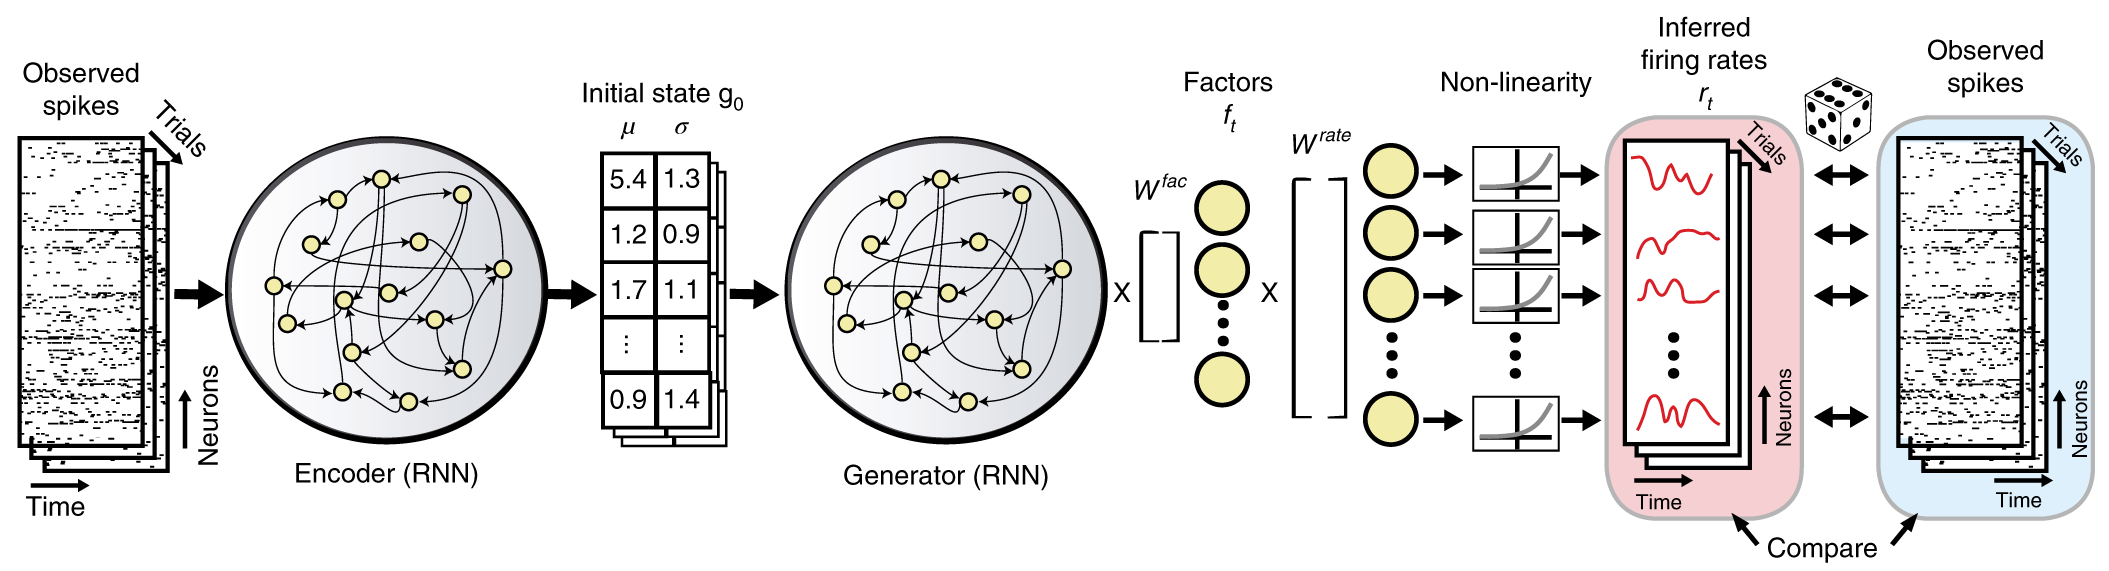



The similarities are quite apparent. The Generator is analogous to model we built in Part 2, which learns the dynamics for generating the latent factors $f_t$ from an initial condition $g_0$. In Part 3 we added the $W^{rate}$ and Non-Linearity to map the latent factors to high-dimensional Inferred Firing Rates. In Part 4, we modified the model training to minimize a loss metric which compared the Inferred Firing Rates to the Observed spikes. Lastly, in Part 5 we added the Encoder, which computes $g_0$ from the Observed Spikes.

There are also several differences between our model and LFADS, some of the main ones being: 
1. LFADS does not estimate a specific initial state $g_0$, but instead estimates a distribution for the initial state (hence the $\mu$ and $\sigma$ in the diagram). 
2. For this tutorial, we only addressed the case of autonomous latent dynamics (such as the Lorenz system) without external inputs. In practice, we expect communication between brain areas, so we would also expect external inputs to have a role in driving the latent dynamics of the neural population. To consider this, the complete version of LFADS implements a "Controller" block, which infers these external inputs to the dynamical system. 

But despite the differences, most of the core concepts which we went over during this tutorial are shared by both models.



Before closing up, we wanted to highlight some of the assumptions we made to model our synthetic neural data:
* Observed spiking data can be modeled as a Poisson process with some underlying firing rates.
* These underlying rates for a population of neurons can be modeled as a mapping from a low-dimensional dynamical system.

If the above do not hold for the specific neural data you work with, the modeling tools we presented may not work as well as they did during this tutorial (since we explicitly considered them as true when generating our synthetic neural data). Nonetheless, recent work has identified that the above assumptions hold for several brain areas and behaviors, and LFADS models trained on diverse datasets are able to uncover firing rates which can estimate behavioral variables better than standard methods. 

With that said, we hope this tutorial was helpful to develop some intuition on some of the fundamental concepts behind LFADS. If you are interested in using LFADS to analyse neural data in the future, we encourage you to go through our *LFADS-Track 2* notebook, which explains the steps needed to prepare data and use it to train an LFADS model.